In [1]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE, r_regression
from sklearn.feature_selection import SelectFromModel, f_classif, mutual_info_classif, chi2
from pycaret.datasets import get_data
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as rfc
import numpy as np
from BioML.features import methods, selection

## Feature selection for regression

In [2]:
data_reg = get_data('insurance')
data = get_data('diabetes')
new_data = data.drop("Class variable", axis=1)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
labels = pd.read_csv("../data/regression_labels.csv", index_col=0)
regre = pd.read_csv("../data/regression.csv", index_col=0)

### Filters

In [4]:
def univariate(X_train, Y_train, num_features, feature_names, filter_name):
    """Features are considered one at the time and we are using statistical filters"""
    print(filter_name)
    filters = {"Fscore": f_classif, "mutual_info": mutual_info_classif, "chi2": chi2, 
               "rFscore": "f_regression", "rmutual_info": mutual_info_regression}
    
    ufilter = SelectKBest(filters[filter_name], k=num_features)
    ufilter.fit(X_train, Y_train)
    scores = {x: v for x, v in zip(feature_names, ufilter.scores_)}
    # sorting the features
    if filter_name != "LaplacianScore":
        if filter_name in ["SpearmanCorr", "PearsonCorr", "KendallCorr", "FechnerCorr"]:
            scores = pd.Series(dict(sorted(scores.items(), key=lambda items: abs(items[1]), reverse=True)))
        else:
            scores = pd.Series(dict(sorted(scores.items(), key=lambda items: items[1], reverse=True)))
    else:
        scores = pd.Series(dict(sorted(scores.items(), key=lambda items: items[1])))
    return scores

def fechner_corr(x, y):
    """Calculate Sample sign correlation (Fechner correlation) for each
    feature. Bigger absolute values mean more important features.

    Parameters
    ----------
    x : array-like, shape (n_samples, n_features)
        The training input samples.
    y : array-like, shape (n_samples,)
        The target values.

    Returns
    -------
    array-like, shape (n_features,) : feature scores

    See Also
    --------

    Examples
    --------
    >>> from ITMO_FS.filters.univariate import fechner_corr
    >>> import numpy as np
    >>> x = np.array([[3, 3, 3, 2, 2], [3, 3, 1, 2, 3], [1, 3, 5, 1, 1],
    ... [3, 1, 4, 3, 1], [3, 1, 2, 3, 1]])
    >>> y = np.array([1, 3, 2, 1, 2])
    >>> fechner_corr(x, y)
    array([-0.2,  0.2, -0.4, -0.2, -0.2])
    """
    y_dev = y - np.mean(y)
    x_dev = x - np.mean(x, axis=0)
    return np.sum(np.sign(x_dev.T * y_dev), axis=1) / x.shape[0]


def regression_filters(reg_func, feature_nums, X_train, Y_train):
    reg_filters = {"mutual_info": mutual_info_regression, "Fscore":f_regression}
    sel = SelectKBest(reg_filters[reg_func], k=feature_nums)
    sel.fit(X_train, Y_train)
    scores = sel.scores_
    p_values = sel.pvalues_
    scores = {x: v for x, v in zip(X_train.columns, scores)}
    scores = pd.Series(dict(sorted(scores.items(), key=lambda items: items[1], reverse=True)))
    return scores, p_values

def chi2_measure(x, y):
    """Calculate the Chi-squared measure for each feature. Bigger values mean
    more important features. This measure works best with discrete features due
    to being based on statistics.

    Parameters
    ----------
    x : array-like, shape (n_samples, n_features)
        The training input samples.
    y : array-like, shape (n_samples,)
        The target values.

    Returns
    -------
    array-like, shape (n_features,) : feature scores

    See Also
    --------
    http://lkm.fri.uni-lj.si/xaigor/slo/clanki/ijcai95z.pdf

    Example
    -------
    >>> from ITMO_FS.filters.univariate import chi2_measure
    >>> from sklearn.preprocessing import KBinsDiscretizer
    >>> import numpy as np
    >>> x = np.array([[3, 3, 3, 2, 2], [3, 3, 1, 2, 3], [1, 3, 5, 1, 1],
    ... [3, 1, 4, 3, 1], [3, 1, 2, 3, 1]])
    >>> y = np.array([1, 3, 2, 1, 2])
    >>> est = KBinsDiscretizer(n_bins=10, encode='ordinal')
    >>> x = est.fit_transform(x)
    >>> chi2_measure(x, y)
    array([ 1.875     ,  0.83333333, 10.        ,  3.75      ,  6.66666667])
    """
    def __chi2(feature):
        values, counts = np.unique(feature, return_counts=True)
        values_map = {val: idx for idx, val in enumerate(values)}
        splits = {cl: np.array([values_map[val] for val in feature[y == cl]]) 
            for cl in classes}
        e = np.vectorize(
            lambda cl: prior_probs[cl] * counts,
            signature='()->(1)')(classes)
        n = np.vectorize(
            lambda cl: np.bincount(splits[cl], minlength=values.shape[0]),
            signature='()->(1)')(classes)
        return np.sum(np.square(e - n) / e)

    classes, counts = np.unique(y, return_counts=True)
    prior_probs = {cl: counts[idx] / x.shape[0] for idx, cl
        in enumerate(classes)}
    
    return np.apply_along_axis(__chi2, 0, x)

In [5]:
transformed_x, scaler_dict = selection.scale("robust", new_data)

In [6]:
features = selection.DataReader(data["Class variable"], new_data)

In [7]:
filters = selection.FeatureSelection("test_c.xlsx")

22-12-2023 12:11:55 INFO Reading the features
22-12-2023 12:11:55 INFO Starting feature selection and using the following parameters
22-12-2023 12:11:55 INFO seed: 1703243515


In [8]:
feature_range = selection.get_range_features(features.features)
feature_range

[2, 3, 4]

In [13]:
filt = {"Fscore", "mutual_info", "chi2", 
               "FechnerCorr", "KendallCorr"}

In [14]:
for x in filt:
    print(x)
    methods.classification_filters(transformed_x, features.label, 5, new_data.columns, x)

Fscore
KendallCorr
chi2
mutual_info
FechnerCorr


22-12-2023 12:12:23 INFO filtering the features


classification filter: mutual_info
classification filter: Fscore
classification filter: chi2
classification filter: FechnerCorr
classification filter: KendallCorr
generating a feature set of 2 dimensions
generating a feature set of 3 dimensions
generating a feature set of 4 dimensions


{'mutual_info_2':      Plasma glucose concentration a 2 hours in an oral glucose tolerance test  \
 0                                                148.0                          
 1                                                 85.0                          
 2                                                183.0                          
 3                                                 89.0                          
 4                                                137.0                          
 ..                                                 ...                          
 763                                              101.0                          
 764                                              122.0                          
 765                                              121.0                          
 766                                              126.0                          
 767                                               93.0                          

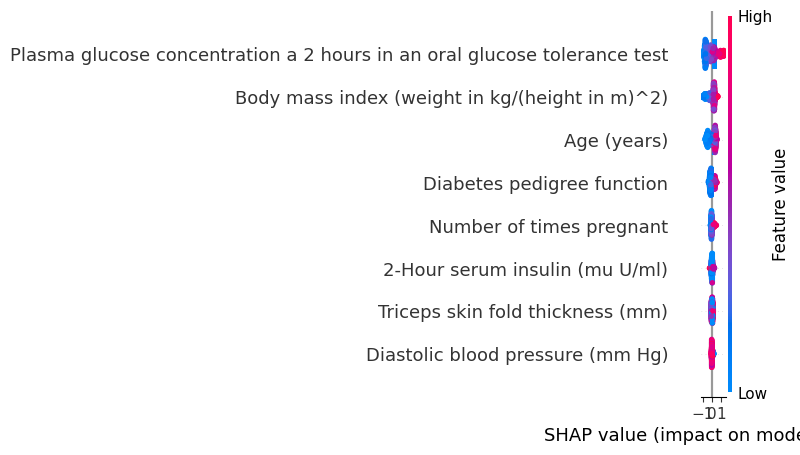

In [15]:
sele = selection.FeatureClassification(filters.seed)
sele.construct_features(features.features, features.label, filters, feature_range)

In [9]:
a = SelectKBest(methods.chi2_measure, k=2)
a.fit(transformed_x, data["Class variable"])

SelectKBest(k=2, score_func=<function chi2_measure at 0x7fc5ba32d800>)

In [10]:
a.scores_

array([ 64.59480869, 269.73324182,  54.933964  ,  73.56289368,
       227.76982979, 286.47025314, 533.02409552, 140.9375197 ])

In [68]:
{x: v for x, v in zip(regre.columns, a.scores_)}

{'0': 0.21354166666666666,
 '1': 0.4088541666666667,
 '2': 0.078125,
 '3': 0.06510416666666667,
 '4': 0.1796875,
 '5': 0.23177083333333334,
 '6': 0.20572916666666666,
 '7': 0.296875}